In [1]:
# Install once if needed:
# install.packages(c("haven","labelled","naniar","psych","lavaan","semTools","dplyr","readr","ggplot2"))

library(haven)      # read_dta preserves Stata labels
library(labelled)   # work with labelled vectors/values
library(dplyr)
library(naniar)
library(psych)      # polychoric, omega
library(lavaan)     # lavCor for polychoric; CFA later
library(semTools)   # reliability helpers
library(ggplot2)
library(readr)

# Paths
infile  <- "data/raw/Thesis data_4.dta"   # change to your file
out_dir <- "data/processed"
dir.create(out_dir, showWarnings = FALSE, recursive = TRUE)
diag_dir <- "outputs/diagnostics"
dir.create(diag_dir, showWarnings = FALSE, recursive = TRUE)



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

This is lavaan 0.6-19
lavaan is FREE software! Please report any bugs.

Attaching package: ‘lavaan’

The following object is masked from ‘package:psych’:

    cor2cov

 
###############################################################################
This is semTools 0.5-7
All users of R (or SEM) are invited to submit functions or ideas for functions.
###############################################################################

Attaching package: ‘semTools’

The following objects are masked from ‘package:psych’:

    reliability, skew


Attaching package: ‘ggplot2’

The following objects are masked from ‘package:psych’:

    %+%, alpha


Attaching package: ‘readr’

The following object is masked from ‘package:semTools’:

    clipboard



In [2]:
dat_raw <- read_dta(infile)  # preserves variable labels and value labels
# Peek at labels
var_label(dat_raw$gender); val_labels(dat_raw$gender)


In [3]:
# Select core fields by names found in your codebook
keep_vars <- c(
  "id","gender","age","residence","academic_year","dept_group","univ_group",
  "family_income","cgpa","living_situation",
  # policy block
  "university_policy","policy_effectiveness","tobacco_free_campus",
  "campus_tobacco_availability","nearby_tobacco_shop",
  # DASS 21
  paste0("dQ", 1:21, c("S","A","D","A","D","S","A","S","A","D",
                       "S","S","D","S","A","D","D","S","A","A","D")[1:21]),
  # BRS items including reversed copies already present
  "rQ1","rQ2","rQ3","rQ4","rQ5","rQ6","rQ2_r","rQ4_r","rQ6_r",
  # scored variables if you want to cross-check later
  "brs_total","brs_mean","brs_cat","dass_dep_cat","dass_anx_cat","dass_str_cat"
)

dat <- dat_raw %>% select(all_of(keep_vars))


In [4]:
# Overall missing percent by variable
miss_tbl <- miss_var_summary(dat)
write_csv(miss_tbl, file.path(diag_dir, "missingness_by_variable.csv"))

# Heatmap-style vis
png(file.path(diag_dir, "missingness_heatmap.png"), width=10000, height=1000, res=300)
vis_miss(dat) + theme_minimal()
dev.off()


In [5]:
# Helper: coerce labelled numeric to ordered factor with correct levels
to_ord <- function(x, levels_vec, labels_vec = NULL){
  # If labelled, fetch labels; otherwise use provided
  if (inherits(x, "labelled")) {
    labs <- val_labels(x)
    # ensure sorted by value
    labs <- labs[order(unclass(labs))]
    lvls <- unname(unclass(labs))
    lbls <- names(labs)
    factor(as.character(as.vector(x)), levels = as.character(lvls), labels = lbls, ordered = TRUE)
  } else {
    factor(as.integer(x), levels = levels_vec, labels = labels_vec, ordered = TRUE)
  }
}

# Identify DASS and BRS columns
dass_items <- grep("^dQ\\d+", names(dat), value = TRUE)
brs_items  <- c("rQ1","rQ2","rQ3","rQ4","rQ5","rQ6")
brs_rev    <- c("rQ2_r","rQ4_r","rQ6_r")

# Convert DASS to ordered 0–3
for (v in dass_items) {
  dat[[v]] <- factor(as.integer(dat[[v]]), levels = 0:3, ordered = TRUE)
}

# Convert BRS (original stems) to ordered 1–5
for (v in brs_items) {
  dat[[v]] <- factor(as.integer(dat[[v]]), levels = 1:5, ordered = TRUE)
}

# Also keep reversed versions as ordered (if you will use them in CFA later)
for (v in brs_rev) {
  if (v %in% names(dat)) dat[[v]] <- factor(as.integer(dat[[v]]), levels = 1:5, ordered = TRUE)
}

# Policy Likerts
ord_vars <- c("policy_effectiveness","tobacco_free_campus")
for (v in ord_vars) if (v %in% names(dat)) dat[[v]] <- factor(as.integer(dat[[v]]), ordered = TRUE)


In [6]:
# DASS polychoric
dass_df <- dat %>% select(all_of(dass_items)) %>% mutate(across(everything(), ~ as.ordered(.)))
dass_poly <- psych::polychoric(dass_df)  # returns $rho and $tau
saveRDS(dass_poly, file.path(out_dir, "polychoric_DASS.rds"))
write.csv(dass_poly$rho, file.path(out_dir, "polychoric_DASS_matrix.csv"), row.names = TRUE)

# BRS polychoric (use original + reversed appropriately later; here use scored orientation: rQ1, rQ3, rQ5, rQ2_r, rQ4_r, rQ6_r)
brs_for_model <- dat %>% select(rQ1, rQ3, rQ5, rQ2_r, rQ4_r, rQ6_r) %>% mutate(across(everything(), ~ as.ordered(.)))
brs_poly <- psych::polychoric(brs_for_model)
saveRDS(brs_poly, file.path(out_dir, "polychoric_BRS.rds"))
write.csv(brs_poly$rho, file.path(out_dir, "polychoric_BRS_matrix.csv"), row.names = TRUE)


Converted non-numeric input to numeric
Converted non-numeric input to numeric


Converted non-numeric input to numeric
Loading required namespace: GPArotation
Converted non-numeric input to numeric
Omega_h for 1 factor is not meaningful, just omega_t


Warning message:
In schmid(m, nfactors, fm, digits, rotate = rotate, n.obs = n.obs,  :
  Omega_h and Omega_asymptotic are not meaningful with one factor


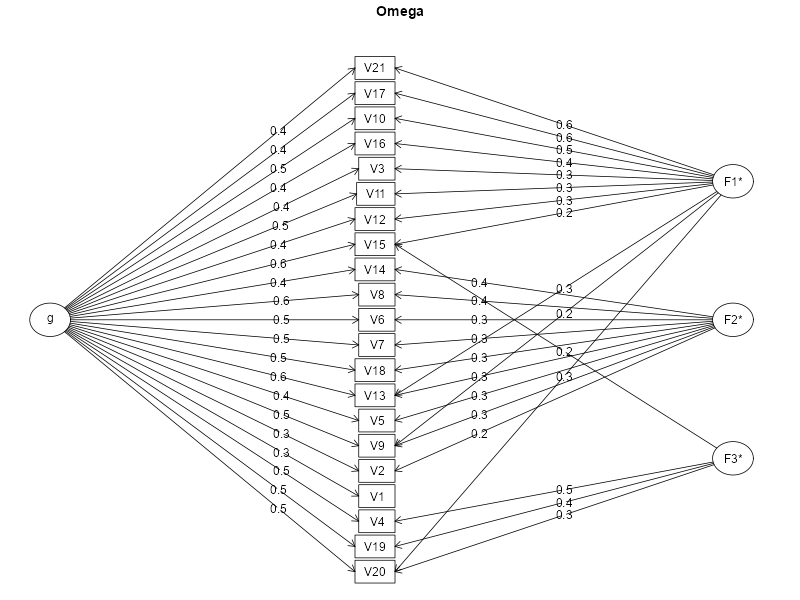

In [7]:
# Convert to numeric 0..3 or 1..5 but keep as ordered; omega will call polychoric()
dass_ord <- dass_df %>% mutate(across(everything(), ~ as.ordered(.)))
dass_omega <- psych::omega(dass_ord, nfactors = 3, poly = TRUE)
capture.output(dass_omega, file = file.path(diag_dir, "omega_DASS.txt"))

brs_ord <- brs_for_model %>% mutate(across(everything(), ~ as.ordered(.)))
brs_omega <- psych::omega(brs_ord, nfactors = 1, poly = TRUE)
capture.output(brs_omega, file = file.path(diag_dir, "omega_BRS.txt"))


In [8]:
brs_for_model <- dat %>% dplyr::select(rQ1, rQ3, rQ5, rQ2_r, rQ4_r, rQ6_r) %>%
  dplyr::mutate(dplyr::across(everything(), ~ as.ordered(.)))
brs_poly <- psych::polychoric(brs_for_model)
# Single-factor reliability; ignore omega_h warning and report omega total
brs_omega <- psych::omega(brs_poly, nfactors = 1, poly = TRUE)
print(brs_omega$omega.tot)          # this is the number to report
print(brs_omega$omega.group)        # will be NA/irrelevant with 1 factor


Converted non-numeric input to numeric
Omega_h for 1 factor is not meaningful, just omega_t


Warning message:
In schmid(m, nfactors, fm, digits, rotate = rotate, n.obs = n.obs,  :
  Omega_h and Omega_asymptotic are not meaningful with one factor


[1] 0.6719756
        total   general        group
g   0.6719756 0.6724214 9.246759e-18
F1* 0.6724214 0.6724214 9.246759e-18


In [9]:
# Pearson for DASS
dass_num <- dat %>% select(all_of(dass_items)) %>% mutate(across(everything(), ~ as.integer(as.character(.))))
pear_cor <- cor(dass_num, use = "pairwise.complete.obs")

# Compare correlation distributions
pc <- as.vector(dass_poly$rho[upper.tri(dass_poly$rho)])
pe <- as.vector(pear_cor[upper.tri(pear_cor)])

cmp <- tibble::tibble(type = rep(c("Polychoric","Pearson"), each = length(pc)),
                      r = c(pc, pe))

png(file.path(diag_dir, "correlation_comparison_hist.png"), width=1200, height=600, res=140)
ggplot(cmp, aes(r, fill = type)) + geom_histogram(position = "identity", alpha = .5, bins = 30) +
  theme_minimal() + labs(title = "DASS item correlations: Polychoric vs Pearson")
dev.off()


In [10]:
saveRDS(dat, file.path(out_dir, "analysis_phase1_ordered.rds"))
# Optional: write a Stata file with labels preserved
# haven::write_dta(dat, path = file.path(out_dir, "analysis_phase1_ordered.dta"))
